In [35]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
from sklearn.metrics import recall_score, confusion_matrix
from scripts.functions import create_model
import matplotlib.pylab as plt
import seaborn as sns


In [2]:
# Create new variables to be used in Keras and the CNN

# number of items to use for training
BATCH_SIZE = 100 

# Number of identifying classes 
#   WE have two, Bloom and no bloom 1/0
NUM_CLASSES = 2 

# number of times to repeat process
EPOCHS = 100

In [3]:

# Load the data
df = pd.read_csv('../../data/cleaned/site1_vineyard.csv')
df.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4


In [4]:
target = df['BGA-Phycocyanin RFU'].apply(lambda x : x/0.2334)
target
dataset = df.drop(columns=['Chlorophyll (ug/L)', 'Chlorophyll RFU'])
dataset['BGA (ug/L)'] = target
dataset.head(5)

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,BGA (ug/L)
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,1.713796
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,1.713796
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,1.713796
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,1.713796
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,1.713796


In [5]:
from datetime import datetime

timestamp = dataset['Date (mm.dd.yyyy)'] + ' '+ dataset['Time 24hr']
timestamp = pd.to_datetime(timestamp)
dataset['Timestamp'] = timestamp
dataset.head()
#converts the date object to a numerical representation of that object
#dataset['date (mm.dd.yyyy)'] = (dataset['date (mm.dd.yyyy)'] - dataset['date (mm.dd.yyyy)'].min()) / np.timedelta64(1,'D')
#dataset.dtypes

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,BGA (ug/L),Timestamp
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,1.713796,2017-05-05 00:00:00
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,1.713796,2017-05-05 00:15:00
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,1.713796,2017-05-05 00:30:00
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,1.713796,2017-05-05 00:45:00
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,1.713796,2017-05-05 01:00:00


In [6]:
# dont need data and time now that we have Timestamp. Lets remove them

dataset = dataset.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
dataset.head(10)


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,BGA (ug/L),Timestamp
0,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,1.713796,2017-05-05 00:00:00
1,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,1.713796,2017-05-05 00:15:00
2,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,1.713796,2017-05-05 00:30:00
3,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,1.713796,2017-05-05 00:45:00
4,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,1.713796,2017-05-05 01:00:00
5,14.92,1850,-100.1,8.36,16.43,89.8,9.02,0.4,1.713796,2017-05-05 01:15:00
6,14.90,1851,-100.1,8.36,16.35,89.7,9.01,0.4,1.713796,2017-05-05 01:30:00
7,14.88,1852,-100.0,8.36,16.40,89.6,9.00,0.4,1.713796,2017-05-05 01:45:00
8,14.84,1850,-99.9,8.36,16.82,89.4,8.99,0.4,1.713796,2017-05-05 02:00:00
9,14.83,1851,-100.0,8.36,16.50,89.4,8.99,0.4,1.713796,2017-05-05 02:15:00


In [7]:
target = dataset['BGA (ug/L)'].apply(lambda x: 1 if x > 20 else 0)
dataset['Bloom'] = target
dataset.dtypes

Temp C                        float64
Sp Cond (uS/cm)                 int64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
BGA (ug/L)                    float64
Timestamp              datetime64[ns]
Bloom                           int64
dtype: object

In [8]:
# lets try to normalize this now....
from sklearn.preprocessing import MinMaxScaler
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)', 'Bloom']
scaler = MinMaxScaler()
ds_scaled = scaler.fit_transform(dataset[dataset_columns])
dataset = pd.DataFrame(ds_scaled,columns=dataset_columns)
dataset.describe()


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),Bloom
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,0.560516,0.893366,0.477889,0.541089,0.090355,0.165126,0.273546,0.005120
std,0.267413,0.070246,0.116241,0.113254,0.085879,0.093899,0.116220,0.071369
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.308195,0.853771,0.426166,0.461538,0.045893,0.117086,0.190000,0.000000
50%,0.640366,0.895882,0.492228,0.553846,0.065216,0.138870,0.264545,0.000000
75%,0.784656,0.956502,0.538860,0.592308,0.102407,0.177672,0.370909,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Functions to take a moving window of the data of 10 time stamps

In [9]:
'''
determines the window size for the daata set
@param dataset - The dataset to get windows for
@param window_size - the size of the window  
@param shift - the amout to shift the window
'''
def windows(dataset, window_size, shift):
    start = 0
    while start+window_size < dataset.shape[0]: 
        yield (int(start), int(start+window_size))
        # shift the window five blocks of time
        start += shift
        if start % 300 == 0:
            print('Window Segmentation {0:.2f}% done'.format(((start+window_size) / dataset.shape[0]) * 100 ))


'''

Segments the dataset based on the parameters that are passed in.
@param dataset - the dataset to segment into window
@param columns - the array of columns from the dataset to be looked at
@param window_size - the size of the window you would like to be looked at. Defualt is 10

'''
def segment_dataset(dataset, columns, target, window_size=10):    
    print('WINDOW SIZE',window_size)
    print('NUMBER OF COULUMNS',len(columns))
    segments = np.empty((0, window_size, len(columns)))
    labels = np.empty((0))
    count = 0
    for (start, end) in windows(dataset, window_size, 1):
        count+=1
        values = dataset[columns][start:end]
        if(values.shape[0] == window_size):
            segments = np.vstack([segments, np.stack([values])])
            # Takes the larger of the two variables if there are more than one. 
            # This makes it more likly to predict a bloom. Can be changed to iloc[0] to
            # be less likly to predict a bloom (more 0s in the label array)
            
            labels = np.append(labels, dataset[target][start:end].mode().iloc[-1])
        else:
            print("No more Windows available... Exiting")
            break
    return (segments, labels)

In [10]:
feature_columns = dataset_columns[:-1]
(segments, labels) = segment_dataset(dataset, feature_columns, 'Bloom', 9)
print('done')

WINDOW SIZE 9
NUMBER OF COULUMNS 7
Window Segmentation 1.63% done
Window Segmentation 3.21% done
Window Segmentation 4.80% done
Window Segmentation 6.38% done
Window Segmentation 7.96% done
Window Segmentation 9.55% done
Window Segmentation 11.13% done
Window Segmentation 12.71% done
Window Segmentation 14.30% done
Window Segmentation 15.88% done
Window Segmentation 17.46% done
Window Segmentation 19.05% done
Window Segmentation 20.63% done
Window Segmentation 22.21% done
Window Segmentation 23.80% done
Window Segmentation 25.38% done
Window Segmentation 26.96% done
Window Segmentation 28.55% done
Window Segmentation 30.13% done
Window Segmentation 31.71% done
Window Segmentation 33.30% done
Window Segmentation 34.88% done
Window Segmentation 36.46% done
Window Segmentation 38.05% done
Window Segmentation 39.63% done
Window Segmentation 41.21% done
Window Segmentation 42.80% done
Window Segmentation 44.38% done
Window Segmentation 45.97% done
Window Segmentation 47.55% done
Window Segm

In [11]:
segments.shape

(18938, 9, 7)

In [12]:
labels.shape

(18938,)

In [13]:
labels

array([0., 0., 0., ..., 0., 0., 0.])

# Shaping the data to be used in the model.

In [14]:
segments = segments.reshape(len(segments),9,7,1)
segments.shape

(18938, 9, 7, 1)

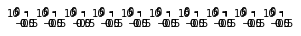

In [15]:
#what the heck does this look like now?
X = 5
y = 40
plt.figure(figsize=(X,y))
columns = 10
for x in range(0, 10):
    plt.subplot(len(segments) / columns + 1, columns, x + 1)
    plt.imshow(segments[x][0]*255,cmap='gray')
#plt.imshow(segments[0][0] * 255, cmap='gray')

In [16]:
labels.shape

(18938,)

In [17]:
labels = labels.reshape(labels.shape[0],1)
labels.shape

(18938, 1)

# Breaking apart training and test data

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(segments, labels, test_size=0.1, random_state=42)

In [19]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (17044, 9, 7, 1)
x_test shape: (1894, 9, 7, 1)
y_train shape: (17044, 1)
y_test shape: (1894, 1)


In [20]:
y_train_mod = ks.utils.to_categorical(y_train, NUM_CLASSES)
y_test_mod = ks.utils.to_categorical(y_test, NUM_CLASSES)
input_shape = (9,7,1)


# Come on, let's create the model already!

In [45]:
import datetime
import time
from keras.layers import Dense, Dropout, Conv2D, Flatten, Activation, MaxPooling2D

# Gets the precision of the different metrics
def create_class_predictions(pred):
    retval = np.array([])
    for row in pred:
        max_value = (-1,-1)
        for index, value in enumerate(row):
            if value > max_value[1]:
                max_value = (index, value)
        retval = np.append(retval, max_value[0])
    return retval


def create_layers(num_layers):
    layers = [Flatten(), Dropout(0.2), Dense(NUM_CLASSES, activation='softmax', input_dim=2)]
    for i in range(0, num_layers):
        layers.insert(0, Conv2D(44, 7, input_shape=input_shape, activation='relu', padding='same'))
    return layers
    
values = []

print("...And Here we go....")
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
print("Started at",st)
max_layers = 2
for i in range(2, max_layers+1):
    layers = create_layers(i)
    model = create_model(44, 7, input_shape, NUM_CLASSES, 0.0001, layers=layers)
    model.fit(x=x_train, y=y_train_mod, batch_size=BATCH_SIZE, epochs=200,verbose=1)
    # What is our score?
    score = model.evaluate(x_train, y_train_mod, verbose=1)
    predictions = model.predict(x_test)
    predict = create_class_predictions(predictions)
    recall = recall_score(y_test.reshape(-1,), predict)
    value = (i, recall)
    values.append(value)
    print("Layers:{}, Recall:{}".format(i, recall))
    print("Current Time: ", st)

st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
print("Finished at",st)
print(values)

...And Here we go....
Started at 2018-12-22 11:07:20
Epoch 1/200
17044/17044 [==============================] - 27s 2ms/step - loss: 0.0845 - acc: 0.9958
Epoch 2/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0227 - acc: 0.9960
Epoch 3/200
17044/17044 [==============================] - 29s 2ms/step - loss: 0.0175 - acc: 0.9960
Epoch 4/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0169 - acc: 0.9958
Epoch 5/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0161 - acc: 0.9962
Epoch 6/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0154 - acc: 0.9958
Epoch 7/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0148 - acc: 0.9960
Epoch 8/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0143 - acc: 0.9961
Epoch 9/200
17044/17044 [==============================] - 29s 2ms/step - loss: 0.0138 - acc: 0.9961
Epoch 10/200
17044/17044 [============

17044/17044 [==============================] - 28s 2ms/step - loss: 0.0035 - acc: 0.9988
Epoch 81/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0033 - acc: 0.9989
Epoch 82/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0040 - acc: 0.9985
Epoch 83/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0034 - acc: 0.9989
Epoch 84/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0030 - acc: 0.9988
Epoch 85/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0033 - acc: 0.9986
Epoch 86/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0033 - acc: 0.9989
Epoch 87/200
17044/17044 [==============================] - 29s 2ms/step - loss: 0.0032 - acc: 0.9988
Epoch 88/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0031 - acc: 0.9989
Epoch 89/200
17044/17044 [==============================] - 28s 2ms/step - loss: 0.0040 - acc: 

17044/17044 [==============================] - 32s 2ms/step - loss: 0.0022 - acc: 0.9990
Epoch 160/200
17044/17044 [==============================] - 32s 2ms/step - loss: 0.0017 - acc: 0.9992
Epoch 161/200
17044/17044 [==============================] - 32s 2ms/step - loss: 0.0022 - acc: 0.9992
Epoch 162/200
17044/17044 [==============================] - 32s 2ms/step - loss: 0.0022 - acc: 0.9992
Epoch 163/200
17044/17044 [==============================] - 32s 2ms/step - loss: 0.0019 - acc: 0.9992
Epoch 164/200
17044/17044 [==============================] - 32s 2ms/step - loss: 0.0022 - acc: 0.9991
Epoch 165/200
17044/17044 [==============================] - 32s 2ms/step - loss: 0.0019 - acc: 0.9991
Epoch 166/200
17044/17044 [==============================] - 32s 2ms/step - loss: 0.0017 - acc: 0.9994
Epoch 167/200
17044/17044 [==============================] - 32s 2ms/step - loss: 0.0016 - acc: 0.9994
Epoch 168/200
17044/17044 [==============================] - 32s 2ms/step - loss: 0.001

In [ ]:
# Lets try iterating over multiple layers and types of layers
values = []


print("...And Here we go....")
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
print("Started at",st)
for num_neurons in range(4, 50):
    for window_size in range(2, 10):
        window = (window_size, window_size)
        layers = [Conv2D(num_neurons, window, input_shape=i_shape, activation='relu', padding='same'),
                  MaxPooling2D(pool_size=window), Conv2D(num_neurons * 2, window_size, activation='relu', padding='same'),
                  MaxPooling2D(pool_size=window), Flatten(), Dropout(0.2), Dense(num_neurons), 
                  Dense(class_number, activation='softmax')]
        model = create_model(num_neurons, window, input_shape, NUM_CLASSES, 0.1, layers=layers)
        model.fit(x=x_train, y=y_train_mod, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
        # What is our score?
        score = model.evaluate(x_train, y_train_mod, verbose=1)
        predictions = model.predict(x_test)
        predict = create_class_predictions(predictions)
        recall = recall_score(y_test.reshape(-1,), predict)
        value = (i, window_size, recall)
        values.append(value)
        print('Number of Neurons: {}\nWindow Size: {}\nRecall:{}'.format(num_neurons, window_size, recall))
        print('{0:.2f}% complete'.format(i))

st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
print("Finished at",st)

...And Here we go....
Started at 2018-12-21 22:11:32
Epoch 1/1000
17044/17044 [==============================] - 5s 268us/step - loss: 0.3223 - acc: 0.9823
Epoch 2/1000
17044/17044 [==============================] - 2s 143us/step - loss: 0.0397 - acc: 0.9960
Epoch 3/1000
17044/17044 [==============================] - 2s 143us/step - loss: 0.0303 - acc: 0.9960
Epoch 4/1000
17044/17044 [==============================] - 2s 143us/step - loss: 0.0298 - acc: 0.9960
Epoch 5/1000
17044/17044 [==============================] - 2s 144us/step - loss: 0.0294 - acc: 0.9960
Epoch 6/1000
17044/17044 [==============================] - 2s 144us/step - loss: 0.0295 - acc: 0.9960
Epoch 7/1000
17044/17044 [==============================] - 3s 147us/step - loss: 0.0282 - acc: 0.9960
Epoch 8/1000
17044/17044 [==============================] - 2s 145us/step - loss: 0.0279 - acc: 0.9960
Epoch 9/1000
17044/17044 [==============================] - 2s 145us/step - loss: 0.0270 - acc: 0.9960
Epoch 10/1000
17044/

17044/17044 [==============================] - 2s 142us/step - loss: 0.0063 - acc: 0.9977
Epoch 80/1000
17044/17044 [==============================] - 2s 143us/step - loss: 0.0062 - acc: 0.9981
Epoch 81/1000
17044/17044 [==============================] - 2s 142us/step - loss: 0.0064 - acc: 0.9975
Epoch 82/1000
17044/17044 [==============================] - 2s 141us/step - loss: 0.0066 - acc: 0.9976
Epoch 83/1000
17044/17044 [==============================] - 2s 142us/step - loss: 0.0064 - acc: 0.9977
Epoch 84/1000
17044/17044 [==============================] - 2s 142us/step - loss: 0.0063 - acc: 0.9977
Epoch 85/1000
17044/17044 [==============================] - 2s 142us/step - loss: 0.0062 - acc: 0.9980
Epoch 86/1000
17044/17044 [==============================] - 2s 141us/step - loss: 0.0059 - acc: 0.9982
Epoch 87/1000
17044/17044 [==============================] - 2s 141us/step - loss: 0.0057 - acc: 0.9982
Epoch 88/1000
17044/17044 [==============================] - 2s 139us/step - l

17044/17044 [==============================] - 2s 118us/step - loss: 0.0039 - acc: 0.9987
Epoch 158/1000
17044/17044 [==============================] - 2s 111us/step - loss: 0.0044 - acc: 0.9984
Epoch 159/1000
17044/17044 [==============================] - 2s 113us/step - loss: 0.0034 - acc: 0.9989
Epoch 160/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0034 - acc: 0.9988
Epoch 161/1000
17044/17044 [==============================] - 2s 113us/step - loss: 0.0037 - acc: 0.9987
Epoch 162/1000
17044/17044 [==============================] - 2s 113us/step - loss: 0.0029 - acc: 0.9989
Epoch 163/1000
17044/17044 [==============================] - 2s 118us/step - loss: 0.0030 - acc: 0.9989
Epoch 164/1000
17044/17044 [==============================] - 2s 117us/step - loss: 0.0031 - acc: 0.9991
Epoch 165/1000
17044/17044 [==============================] - 2s 119us/step - loss: 0.0038 - acc: 0.9988
Epoch 166/1000
17044/17044 [==============================] - 2s 118us

17044/17044 [==============================] - 2s 115us/step - loss: 0.0024 - acc: 0.9991
Epoch 236/1000
17044/17044 [==============================] - 2s 115us/step - loss: 0.0027 - acc: 0.9987
Epoch 237/1000
17044/17044 [==============================] - 2s 122us/step - loss: 0.0022 - acc: 0.9992
Epoch 238/1000
17044/17044 [==============================] - 2s 118us/step - loss: 0.0022 - acc: 0.9992
Epoch 239/1000
17044/17044 [==============================] - 2s 125us/step - loss: 0.0021 - acc: 0.9991
Epoch 240/1000
17044/17044 [==============================] - 2s 121us/step - loss: 0.0029 - acc: 0.9990
Epoch 241/1000
17044/17044 [==============================] - 2s 115us/step - loss: 0.0021 - acc: 0.9994
Epoch 242/1000
17044/17044 [==============================] - 2s 118us/step - loss: 0.0022 - acc: 0.9993
Epoch 243/1000
17044/17044 [==============================] - 2s 115us/step - loss: 0.0027 - acc: 0.9992
Epoch 244/1000
17044/17044 [==============================] - 2s 114us

17044/17044 [==============================] - 2s 112us/step - loss: 0.0020 - acc: 0.9992
Epoch 313/1000
17044/17044 [==============================] - 2s 109us/step - loss: 0.0018 - acc: 0.9992
Epoch 314/1000
17044/17044 [==============================] - 2s 117us/step - loss: 0.0017 - acc: 0.9994
Epoch 315/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0020 - acc: 0.9993
Epoch 316/1000
17044/17044 [==============================] - 2s 115us/step - loss: 0.0024 - acc: 0.9991
Epoch 317/1000
17044/17044 [==============================] - 2s 117us/step - loss: 0.0027 - acc: 0.9989
Epoch 318/1000
17044/17044 [==============================] - 2s 120us/step - loss: 0.0019 - acc: 0.9994
Epoch 319/1000
17044/17044 [==============================] - 2s 117us/step - loss: 0.0022 - acc: 0.9994
Epoch 320/1000
17044/17044 [==============================] - 2s 118us/step - loss: 0.0018 - acc: 0.9995
Epoch 321/1000
17044/17044 [==============================] - 2s 117us

Epoch 390/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0015 - acc: 0.9995
Epoch 391/1000
17044/17044 [==============================] - 2s 110us/step - loss: 0.0012 - acc: 0.9996
Epoch 392/1000
17044/17044 [==============================] - 2s 111us/step - loss: 0.0041 - acc: 0.9989
Epoch 393/1000
17044/17044 [==============================] - 2s 111us/step - loss: 0.0017 - acc: 0.9994
Epoch 394/1000
17044/17044 [==============================] - 2s 110us/step - loss: 0.0013 - acc: 0.9996
Epoch 395/1000
17044/17044 [==============================] - 2s 110us/step - loss: 0.0013 - acc: 0.9995
Epoch 396/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0014 - acc: 0.9994
Epoch 397/1000
17044/17044 [==============================] - 2s 111us/step - loss: 0.0014 - acc: 0.9994
Epoch 398/1000
17044/17044 [==============================] - 2s 111us/step - loss: 0.0024 - acc: 0.9991
Epoch 399/1000
17044/17044 [===========================

17044/17044 [==============================] - 2s 113us/step - loss: 0.0011 - acc: 0.9996
Epoch 468/1000
17044/17044 [==============================] - 2s 110us/step - loss: 0.0010 - acc: 0.9996
Epoch 469/1000
17044/17044 [==============================] - 2s 111us/step - loss: 0.0016 - acc: 0.9995
Epoch 470/1000
17044/17044 [==============================] - 2s 114us/step - loss: 0.0016 - acc: 0.9995
Epoch 471/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0019 - acc: 0.9994
Epoch 472/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0012 - acc: 0.9996
Epoch 473/1000
17044/17044 [==============================] - 2s 110us/step - loss: 0.0022 - acc: 0.9990
Epoch 474/1000
17044/17044 [==============================] - 2s 115us/step - loss: 0.0012 - acc: 0.9995
Epoch 475/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0012 - acc: 0.9997
Epoch 476/1000
17044/17044 [==============================] - 2s 111us

17044/17044 [==============================] - 2s 111us/step - loss: 0.0022 - acc: 0.9992
Epoch 545/1000
17044/17044 [==============================] - 2s 112us/step - loss: 8.3013e-04 - acc: 0.9998
Epoch 546/1000
17044/17044 [==============================] - 2s 110us/step - loss: 0.0035 - acc: 0.9987
Epoch 547/1000
17044/17044 [==============================] - 2s 110us/step - loss: 0.0014 - acc: 0.9995
Epoch 548/1000
17044/17044 [==============================] - 2s 121us/step - loss: 9.4839e-04 - acc: 0.9996
Epoch 549/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0014 - acc: 0.9995
Epoch 550/1000
17044/17044 [==============================] - 2s 113us/step - loss: 0.0012 - acc: 0.9997
Epoch 551/1000
17044/17044 [==============================] - 2s 111us/step - loss: 0.0012 - acc: 0.9996
Epoch 552/1000
17044/17044 [==============================] - 2s 113us/step - loss: 0.0014 - acc: 0.9995
Epoch 553/1000
17044/17044 [==============================] - 

17044/17044 [==============================] - 2s 111us/step - loss: 0.0012 - acc: 0.9996
Epoch 621/1000
17044/17044 [==============================] - 2s 113us/step - loss: 0.0017 - acc: 0.9994
Epoch 622/1000
17044/17044 [==============================] - 2s 114us/step - loss: 5.4882e-04 - acc: 0.9998
Epoch 623/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0036 - acc: 0.9994
Epoch 624/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0016 - acc: 0.9995
Epoch 625/1000
17044/17044 [==============================] - 2s 110us/step - loss: 3.9152e-04 - acc: 0.9999
Epoch 626/1000
17044/17044 [==============================] - 2s 112us/step - loss: 0.0012 - acc: 0.9996
Epoch 627/1000
17044/17044 [==============================] - 2s 111us/step - loss: 5.8383e-04 - acc: 0.9998
Epoch 628/1000
17044/17044 [==============================] - 2s 115us/step - loss: 0.0012 - acc: 0.9996
Epoch 629/1000
17044/17044 [==============================

17044/17044 [==============================] - 2s 112us/step - loss: 9.9025e-04 - acc: 0.9996
Epoch 697/1000
17044/17044 [==============================] - 2s 111us/step - loss: 4.4666e-04 - acc: 0.9999
Epoch 698/1000
17044/17044 [==============================] - 2s 111us/step - loss: 5.6002e-04 - acc: 0.9998
Epoch 699/1000
17044/17044 [==============================] - 2s 111us/step - loss: 2.1808e-04 - acc: 1.0000
Epoch 700/1000
17044/17044 [==============================] - 2s 109us/step - loss: 6.1134e-04 - acc: 0.9998
Epoch 701/1000
17044/17044 [==============================] - 2s 114us/step - loss: 0.0035 - acc: 0.9987
Epoch 702/1000
17044/17044 [==============================] - 2s 114us/step - loss: 5.2210e-04 - acc: 0.9999
Epoch 703/1000
17044/17044 [==============================] - 2s 112us/step - loss: 4.5642e-04 - acc: 0.9999
Epoch 704/1000
17044/17044 [==============================] - 2s 111us/step - loss: 3.9361e-04 - acc: 0.9998
Epoch 705/1000
17044/17044 [==========

17044/17044 [==============================] - 2s 111us/step - loss: 3.6453e-04 - acc: 0.9999
Epoch 772/1000
17044/17044 [==============================] - 2s 110us/step - loss: 5.5620e-04 - acc: 0.9997
Epoch 773/1000
17044/17044 [==============================] - 2s 109us/step - loss: 0.0018 - acc: 0.9992
Epoch 774/1000
17044/17044 [==============================] - 2s 111us/step - loss: 7.0502e-04 - acc: 0.9996
Epoch 775/1000
17044/17044 [==============================] - 2s 110us/step - loss: 7.2855e-04 - acc: 0.9997
Epoch 776/1000
17044/17044 [==============================] - 2s 110us/step - loss: 4.7648e-04 - acc: 0.9999
Epoch 777/1000
17044/17044 [==============================] - 2s 113us/step - loss: 2.4921e-04 - acc: 0.9999
Epoch 778/1000
17044/17044 [==============================] - 2s 112us/step - loss: 2.2845e-04 - acc: 1.0000
Epoch 779/1000
17044/17044 [==============================] - 2s 111us/step - loss: 3.1994e-04 - acc: 0.9999
Epoch 780/1000
17044/17044 [==========

17044/17044 [==============================] - 2s 114us/step - loss: 9.0077e-04 - acc: 0.9997
Epoch 847/1000
17044/17044 [==============================] - 2s 111us/step - loss: 3.2099e-04 - acc: 0.9999
Epoch 848/1000
17044/17044 [==============================] - 2s 111us/step - loss: 3.9323e-04 - acc: 0.9998
Epoch 849/1000
17044/17044 [==============================] - 2s 109us/step - loss: 1.4444e-04 - acc: 1.0000
Epoch 850/1000
17044/17044 [==============================] - 2s 112us/step - loss: 9.2135e-05 - acc: 1.0000
Epoch 851/1000
17044/17044 [==============================] - 2s 110us/step - loss: 0.0011 - acc: 0.9997
Epoch 852/1000
17044/17044 [==============================] - 2s 112us/step - loss: 5.1419e-04 - acc: 0.9999
Epoch 853/1000
17044/17044 [==============================] - 2s 119us/step - loss: 6.3607e-04 - acc: 0.9998
Epoch 854/1000
17044/17044 [==============================] - 2s 118us/step - loss: 3.2821e-04 - acc: 0.9998
Epoch 855/1000
17044/17044 [==========

17044/17044 [==============================] - 2s 113us/step - loss: 0.0012 - acc: 0.9995
Epoch 922/1000
17044/17044 [==============================] - 2s 115us/step - loss: 3.1123e-04 - acc: 0.9998
Epoch 923/1000
17044/17044 [==============================] - 2s 115us/step - loss: 5.4385e-04 - acc: 0.9997
Epoch 924/1000
17044/17044 [==============================] - 2s 117us/step - loss: 1.5616e-04 - acc: 0.9999
Epoch 925/1000
17044/17044 [==============================] - 2s 116us/step - loss: 0.0012 - acc: 0.9994
Epoch 926/1000
17044/17044 [==============================] - 2s 115us/step - loss: 3.4853e-04 - acc: 0.9999
Epoch 927/1000
17044/17044 [==============================] - 2s 115us/step - loss: 0.0032 - acc: 0.9991
Epoch 928/1000
17044/17044 [==============================] - 2s 118us/step - loss: 2.2205e-04 - acc: 0.9999
Epoch 929/1000
17044/17044 [==============================] - 2s 120us/step - loss: 1.2761e-04 - acc: 1.0000
Epoch 930/1000
17044/17044 [==================

17044/17044 [==============================] - 2s 120us/step - loss: 1.0245e-04 - acc: 1.0000
Epoch 997/1000
17044/17044 [==============================] - 2s 120us/step - loss: 8.1677e-05 - acc: 1.0000
Epoch 998/1000
17044/17044 [==============================] - 2s 114us/step - loss: 8.3064e-05 - acc: 1.0000
Epoch 999/1000
17044/17044 [==============================] - 2s 124us/step - loss: 1.3985e-04 - acc: 1.0000
Epoch 1000/1000
17044/17044 [==============================] - 3s 158us/step
Layers:20, Recall:1.0
Finished at 2018-12-21 22:46:00
dict_keys(['loss', 'acc'])


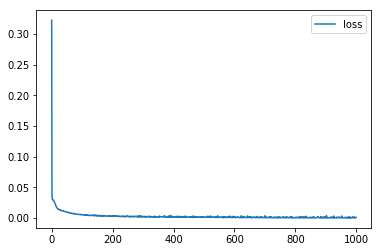

In [41]:
#Checking for minimum values that give the best recall.
values = []
neurons = 20
print("...And Here we go....")
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
print("Started at",st)
model = create_model(neurons, 7, input_shape, NUM_CLASSES, 0.0001)
history = model.fit(x=x_train, y=y_train_mod, batch_size=100, epochs=200, verbose=1)
# What is our score?
score = model.evaluate(x_train, y_train_mod, verbose=1)
predictions = model.predict(x_test)
predict = create_class_predictions(predictions)
recall = recall_score(y_test.reshape(-1,), predict)
value = (neurons, recall)
values.append(value)
print("Layers:{}, Recall:{}".format(neurons, recall))
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
print("Finished at",st)
print(history.history.keys())
sns.lineplot(data=pd.DataFrame({'loss': history.history['loss']}))

## Save the model for deployment

In [ ]:
# ignoring dropout for deployment
K.set_learning_phase(0)
 
# Set a file path to save the model in.
model_name = "cnn_model"
model_version = "1"
tf_path = "./../../saved_models/{}/{}".format(model_name, model_version)
 
# Get the session from the Keras back-end to save the model in TF format.
with K.get_session() as sess:
    tf.saved_model.simple_save(sess, tf_path, inputs={'input': model.input}, outputs={t.name: t for t in model.outputs})
